In [486]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import openai
import re
import time
from scripts.prepare_data_helpers import prepare_examples, create_query
import spacy
import textacy
from dotenv import load_dotenv

load_dotenv()
nlp = spacy.load('en_core_web_sm')

from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB
import xgboost as xgb
import shap

## Prepare Data

In [487]:
train1 = pd.read_csv('../../e-SNLI/dataset/esnli_train_1.csv')
train2 = pd.read_csv('../../e-SNLI/dataset/esnli_train_2.csv')
train = pd.concat([train1, train2])
dev = pd.read_csv('../../e-SNLI/dataset/esnli_dev.csv')
test = pd.read_csv('../../e-SNLI/dataset/esnli_test.csv')

train = train.dropna(subset=['Sentence1', 'Sentence2', 'Explanation_1'])
train = train.reset_index(drop=True)

np.random.seed(12345) # seed for numpy package
test_indices = list(np.random.choice(test.index.values, size=1000, replace=False))
test = test.loc[test_indices]
test = test.reset_index(drop=True)

In [488]:
gpt_pred = pd.read_csv("../output_data/svo_structure_4.csv", sep=";")
gpt2 = pd.read_csv("../output_data/svo_structure_gpt2.csv", sep=";")

# Transform list to single string

# GPT-3
gpt_pred.reduced_expl = [i.replace("'", " ").replace(" ", "").strip("][").replace(",", " ") for i in gpt_pred.reduced_expl]
gpt_pred.pos_expl = [i.replace("'", " ").replace(" ", "").strip("][").replace(",", " ") for i in gpt_pred.pos_expl]

# Gold Explanations
gpt_pred.reduced_gold_expl = [i.replace("'", " ").replace(" ", "").strip("][").replace(",", " ") for i in gpt_pred.reduced_gold_expl]
gpt_pred.pos_gold_expl = [i.replace("'", " ").replace(" ", "").strip("][").replace(",", " ") for i in gpt_pred.pos_gold_expl]

# GPT-2
gpt2.reduced_expl = [i.replace("'", " ").replace(" ", "").strip("][").replace(",", " ") for i in gpt2.reduced_expl]
gpt2.pos_expl = [i.replace("'", " ").replace(" ", "").strip("][").replace(",", " ") for i in gpt2.pos_expl]
gpt2["pred_label"] = gpt2.labels

In [489]:
gpt2.head()

,Unnamed: 0,index,cls_labels,groups,premise,hypothesis,explanations,labels,data_id,generated,S1_SVO,S2_SVO,reduced_expl,pos_expl,pred_label
0,123852,123852,2,2023529314.jpg#4r1e,Man enjoying life while skydiving,A person is skydiving,"A man is a person. If a person is ""enjoying li...",2,esnli,A man is a person.,"[(Man, enjoying, life)]","[(person, skydiving, None)]",be S2_Subj,man be S2_NOUN,2
1,272061,272061,0,441489325.jpg#2r1c,A red-haired woman in a white and purple outfi...,A woman is next to a blue SUV.,A red sports car cannot be a blue SUV.,0,esnli,A red sports car is not a blue SUV.,[],[],be not,S1_ADJ S1_NOUN S1_NOUN be not S2_ADJ S2_PROPN,0
2,140514,140514,2,188244881.jpg#3r1e,A man is standing at a bus stop reading a paper.,A person is at a bus stop.,A man is a person and standing at is same as at,2,esnli,A man is a person.,"[(man, standing, None)]",[],S1_Subj be,S1_NOUN be S2_NOUN,2
3,57451,57451,0,284028406.jpg#0r1c,"A man wearing a gray cap, gold jewelry and win...",There is a man swimming.,"One does not typically wear a gray cap, gold j...",0,esnli,"A man wearing a gray cap, gold jewelry and win...","[(man, wearing, cap), (man, looking, None)]",[],S1_Subj S1_Verb S1_Obj S1_Verb be not same S1_...,S1S2_NOUN S1_VERB S1_ADJ S1_NOUN S1_NOUN S1_NO...,0
4,166846,166846,0,7599430126.jpg#4r1c,A man wearing a mask plays music by the side o...,A man is walking through an airport.,Playing music on the side of the road cannot t...,0,esnli,One cannot be walking through an airport and b...,"[(man, plays, None), (man, plays, music)]","[(man, walking, None)]",not walk S2_Verb same,not be S2_VERB S2_NOUN S1_NOUN time,0


In [490]:
gpt_pred.head()

,Unnamed: 0.1,Unnamed: 0,pairID,gold_label,Sentence1,Sentence2,Explanation_1,Sentence1_marked_1,Sentence2_marked_1,Sentence1_Highlighted_1,...,Sentence2_Highlighted_3,prompt,pred_explanation,pred_label,S1_SVO,S2_SVO,reduced_expl,pos_expl,reduced_gold_expl,pos_gold_expl
0,0,0,4813951931.jpg#3r1e,entailment,A young man in an orange hat walks his bicycle...,A man in an orange hat walks his bike down a s...,"A bicycle and a bike, are the same object.",A young man in an orange hat walks his *bicyc...,A man in an orange hat walks his *bike* down ...,9,...,"1,5,4,3,11,9,8,7,6",Statement: Two african women bike down a dirt ...,A young man in an orange hat is a rephrasing o...,entailment,"[(man, walks, bicycle)]","[(man, walks, bike)]",S1S2_Subj be,S1_ADJ S1S2_NOUN S1S2_ADJ S1S2_NOUN be rephras...,S1_Obj S2_Obj be same,S1_NOUN S2_NOUN be object
1,1,1,4678320536.jpg#1r1c,contradiction,A woman standing with smile on her face and sh...,A woman stands holding her baby and crying.,If a woman has a smile on her face then she is...,A woman standing with *smile* *on* *her* *face...,A woman stands holding her baby and *crying.*,"4,5,6,7",...,"1,7",Statement: A man with a striped shirt and glas...,"The woman is smiling and holding a wood, not a...",contradiction,"[(woman, holding, wood), (she, holding, wood)]","[(woman, stands, None)]",S1S2_Subj smile S1_Verb S1_Obj,S1S2_NOUN be S1_NOUN S1S2_VERB S1_NOUN not S2_...,S1S2_Subj S1_Subj not cry,S1S2_NOUN S1_NOUN S1_NOUN be not S2_VERB sadly
2,2,2,661749711.jpg#2r1e,entailment,A dog jumps to catch a red ball outside.,the dog is jumping.,Jumping is an action needed to catch a ball.,A *dog* *jumps* to *catch* a red *ball* *outs...,the *dog* is *jumping.*,"2,7,8,1,4",...,3,Statement: a lone rock climber in a harness cl...,The statement implies that the dog is jumping ...,entailment,"[(dog, jumps, None)]","[(dog, jumping, None)]",imply S1S2_Subj S1S2_Verb,statement imply S1S2_NOUN be S1S2_VERB S1_VERB...,be,jumping be action need S1_VERB S1_NOUN
3,3,3,44904567.jpg#1r1c,contradiction,A man wielding an electric razor is gleefully ...,There is only one person present.,There cannot be one person present if one man ...,A *man* wielding an electric razor is gleefull...,There is only *one* *person* *present.*,"1,10,11",...,"2,3,4",Statement: A young girl is climbing on a woode...,"There are two people present, the man wielding...",contradiction,"[(man, wielding, razor), (man, wielding, None)]",[],be S1_Subj S1_Verb S1_Obj S1_Subj be be,be people S2_ADJ S1_NOUN S1_VERB S1_ADJ S1_NOU...,not be S1_Subj be S1_Subj,not be S2_NOUN S2_ADJ S1_NOUN be S1_VERB S1_NO...
4,4,4,32542645.jpg#0r1n,neutral,A group of people stares at a wall that is fil...,A group of people analyze art together,Not necessary that they analyze the art.,A group of people stares at a wall that is fil...,A group of people *analyze* art together,{},...,"4,6",Statement: A girl in a red and pink shirt is c...,Staring at drawings is a form of analyzing art.,entailment,"[(group, stares, None), (that, filled, None)]","[(group, analyze, art)]",S1_Verb be S2_Verb S2_Obj,S1_VERB S1_NOUN be form S2_VERB S2_NOUN,not necessary S1_Subj S2_Verb S2_Obj,not necessary S2_VERB S2_NOUN


In [491]:
nb_results_SVO = pd.DataFrame()
nb_results_POS = pd.DataFrame()
nb_results_full = pd.DataFrame()

# Reduced GPT-3 Explanations

## SVO Structure

### Naive Bayes

In [492]:
vectorizer = CountVectorizer(ngram_range=(1, 4))
X = vectorizer.fit_transform(gpt_pred.reduced_expl)

In [493]:
print(X.toarray())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [494]:
X_train, X_test, y_train, y_test = train_test_split(X.toarray(), pd.Series([x.lower() for x in gpt_pred.pred_label]), test_size=0.5, random_state=12345)

In [495]:
mnb = MultinomialNB()
y_pred = mnb.fit(X_train, y_train).predict(X_test)
print("Number of mislabeled points out of in total %d points : %d"
      % (X_test.shape[0], (y_test != y_pred).sum()))
print(f"Accuracy: {(y_test == y_pred).mean()}")

Number of mislabeled points out of in total 500 points : 113
Accuracy: 0.774


In [496]:
metrics.confusion_matrix(y_test, y_pred)

array([[122,  39,   8],
       [ 23, 218,   4],
       [ 16,  23,  47]])

In [497]:
y_train.value_counts() / y_train.shape[0]

entailment       0.476
contradiction    0.366
neutral          0.158
dtype: float64

In [498]:
np.exp(mnb.class_log_prior_)

array([0.366, 0.476, 0.158])

In [499]:
cond_prob_Xi_given_not_yj = np.zeros(mnb.feature_log_prob_.shape)
for j in range(3):
    log_joint_prob_m = mnb.feature_log_prob_[j != np.array([0,1,2]),:][0,:] + mnb.class_log_prior_[j != np.array([0,1,2])][0]
    log_joint_prob_k = mnb.feature_log_prob_[j != np.array([0,1,2]),:][1,:] + mnb.class_log_prior_[j != np.array([0,1,2])][1]
    joint_prob_not_j = np.exp(log_joint_prob_m) + np.exp(log_joint_prob_k)
    cond_prob_Xi_given_not_yj[j,:] = joint_prob_not_j / (1 - np.exp(mnb.class_log_prior_[j]))
prob_increase = (np.exp(mnb.feature_log_prob_) - cond_prob_Xi_given_not_yj) / cond_prob_Xi_given_not_yj * np.exp(mnb.feature_log_prob_)

In [500]:
nb_results_SVO["gpt3_contradiction"] = vectorizer.get_feature_names_out()[prob_increase.argsort()[0,::-1]][:50]
nb_results_SVO["gpt3_entailment"] = vectorizer.get_feature_names_out()[prob_increase.argsort()[1,::-1]][:50]
nb_results_SVO["gpt3_neutral"] = vectorizer.get_feature_names_out()[prob_increase.argsort()[2,::-1]][:50]
vectorizer.get_feature_names_out()[prob_increase.argsort()[:,::-1]][:50]

array([['be different', 'not', 'different', ..., 'imply', 's1s2_verb',
        's1s2_subj'],
       ['imply', 'imply s1s2_subj', 's1s2_verb', ..., 's1_verb s2_verb',
        'different', 'same'],
       ['not mean', 'mean', 'not mean s2_verb', ..., 's1s2_subj',
        's1_verb', 's2_verb']], dtype=object)

### XGBoost

In [501]:
xg_reg = xgb.XGBClassifier(colsample_bytree = 0.3, learning_rate = 0.1,
                          max_depth = 5, alpha = 10, n_estimators = 100)
y_train_numeric = np.array([0 if x == "contradiction" else x for x in y_train])
y_train_numeric = np.array([1 if x == "entailment" else x for x in y_train_numeric])
y_train_numeric = np.array([2 if x == "neutral" else x for x in y_train_numeric]).astype(int)

y_test_numeric = np.array([0 if x == "contradiction" else x for x in y_test])
y_test_numeric = np.array([1 if x == "entailment" else x for x in y_test_numeric])
y_test_numeric = np.array([2 if x == "neutral" else x for x in y_test_numeric]).astype(int)

xg_reg.fit(X_train,y_train_numeric)
#xg_reg.fit(X_train,np.repeat(1,X_train.shape[0]))

preds = xg_reg.predict(X_test)

In [502]:
print("Number of mislabeled points out of in total %d points : %d"
      % (X_test.shape[0], (y_test_numeric != preds).sum()))
print(f"Accuracy: {(y_test_numeric == preds).mean()}")

Number of mislabeled points out of in total 500 points : 105
Accuracy: 0.79


In [503]:
shap.initjs()
explainer = shap.TreeExplainer(xg_reg)
shap_values = explainer.shap_values(X)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [504]:
vectorizer.get_feature_names_out()[xg_reg.feature_importances_.argsort()[::-1]]

array(['not', 'be different', 'not mean', ..., 's1s2_subj s1_obj not',
       's1s2_subj s1_obj', 'add'], dtype=object)

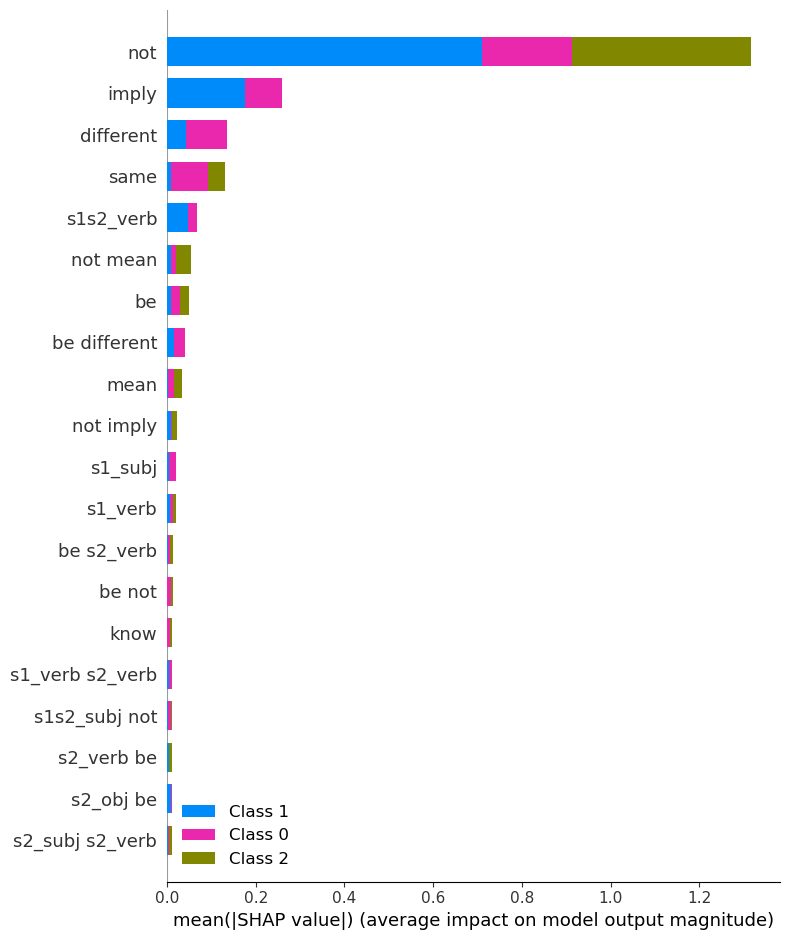

In [505]:
shap.summary_plot(shap_values, features=X, feature_names=vectorizer.get_feature_names_out())

## POS Tags

### Naive Bayes

In [506]:
vectorizer = CountVectorizer(ngram_range=(1, 3))
X = vectorizer.fit_transform(gpt_pred.pos_expl)

In [507]:
print(X.toarray())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [508]:
X_train, X_test, y_train, y_test = train_test_split(X.toarray(), pd.Series([x.lower() for x in gpt_pred.pred_label]), test_size=0.5, random_state=12345)

In [509]:
y_test.value_counts() / y_test.shape[0]

entailment       0.490
contradiction    0.338
neutral          0.172
dtype: float64

In [510]:
mnb = MultinomialNB()
y_pred = mnb.fit(X_train, y_train).predict(X_test)
print("Number of mislabeled points out of in total %d points : %d"
      % (X_test.shape[0], (y_test != y_pred).sum()))
print(f"Accuracy: {(y_test == y_pred).mean()}")

Number of mislabeled points out of in total 500 points : 76
Accuracy: 0.848


In [511]:
# Accuracy of GPT-3 predicted labels
np.mean(gpt_pred.pred_label.loc[y_test.index] == gpt_pred.gold_label.loc[y_test.index])

0.782

In [512]:
# Accuracy of GPT-3 predicted labels that were correctly predicted by the Naive Bayes Classifier
np.mean(gpt_pred.pred_label.loc[y_test.index][y_test == y_pred] == gpt_pred.gold_label.loc[y_test.index][y_test == y_pred])

0.7806603773584906

In [513]:
# Accuracy of GPT-3 predicted labels that were NOT correctly predicted by the Naive Bayes Classifier
np.mean(gpt_pred.pred_label.loc[y_test.index][y_test != y_pred] == gpt_pred.gold_label.loc[y_test.index][y_test != y_pred])

0.7894736842105263

In [514]:
metrics.confusion_matrix(y_test, y_pred)

array([[136,  23,  10],
       [ 10, 231,   4],
       [ 17,  12,  57]])

In [515]:
y_train.value_counts() / y_train.shape[0]

entailment       0.476
contradiction    0.366
neutral          0.158
dtype: float64

In [516]:
np.exp(mnb.class_log_prior_)

array([0.366, 0.476, 0.158])

In [517]:
cond_prob_Xi_given_not_yj = np.zeros(mnb.feature_log_prob_.shape)
for j in range(3):
    log_joint_prob_m = mnb.feature_log_prob_[j != np.array([0,1,2]),:][0,:] + mnb.class_log_prior_[j != np.array([0,1,2])][0]
    log_joint_prob_k = mnb.feature_log_prob_[j != np.array([0,1,2]),:][1,:] + mnb.class_log_prior_[j != np.array([0,1,2])][1]
    joint_prob_not_j = np.exp(log_joint_prob_m) + np.exp(log_joint_prob_k)
    cond_prob_Xi_given_not_yj[j,:] = joint_prob_not_j / (1 - np.exp(mnb.class_log_prior_[j]))
prob_increase = (np.exp(mnb.feature_log_prob_) - cond_prob_Xi_given_not_yj) / cond_prob_Xi_given_not_yj * np.exp(mnb.feature_log_prob_)

In [518]:
nb_results_POS["gpt3_contradiction"] = vectorizer.get_feature_names_out()[prob_increase.argsort()[0,::-1]][:50]
nb_results_POS["gpt3_entailment"] = vectorizer.get_feature_names_out()[prob_increase.argsort()[1,::-1]][:50]
nb_results_POS["gpt3_neutral"] = vectorizer.get_feature_names_out()[prob_increase.argsort()[2,::-1]][:50]
vectorizer.get_feature_names_out()[prob_increase.argsort()[:,::-1]][:50]

array([['time', 'be different', 'different', ..., 's1s2_noun be', 'be',
        's1s2_noun'],
       ['s1s2_noun', 'imply', 'imply s1s2_noun', ..., 's2_verb s2_noun',
        's2_verb', 's2_noun'],
       ['not mean', 'mean', 'not mean be', ..., 's1s2_noun', 'be',
        's1_noun']], dtype=object)

### XGBoost

In [519]:
xg_reg = xgb.XGBClassifier(colsample_bytree = 0.3, learning_rate = 0.1,
                          max_depth = 5, alpha = 10, n_estimators = 100)
y_train_numeric = np.array([0 if x == "contradiction" else x for x in y_train])
y_train_numeric = np.array([1 if x == "entailment" else x for x in y_train_numeric])
y_train_numeric = np.array([2 if x == "neutral" else x for x in y_train_numeric]).astype(int)

y_test_numeric = np.array([0 if x == "contradiction" else x for x in y_test])
y_test_numeric = np.array([1 if x == "entailment" else x for x in y_test_numeric])
y_test_numeric = np.array([2 if x == "neutral" else x for x in y_test_numeric]).astype(int)

xg_reg.fit(X_train,y_train_numeric)
#xg_reg.fit(X_train,np.repeat(1,X_train.shape[0]))

preds = xg_reg.predict(X_test)

In [520]:
np.mean([preds[i] == y_test_numeric[i] for i in range(len(preds))])

0.866

In [521]:
print("Number of mislabeled points out of in total %d points : %d"
      % (X_test.shape[0], (y_test_numeric != preds).sum()))
print(f"Accuracy: {(y_test_numeric == preds).mean()}")

Number of mislabeled points out of in total 500 points : 67
Accuracy: 0.866


In [522]:
shap.initjs()
explainer = shap.TreeExplainer(xg_reg)
shap_values = explainer.shap_values(X)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [523]:
vectorizer.get_feature_names_out()[xg_reg.feature_importances_.argsort()[::-1]]

array(['not', 'different', 's2_noun not', ..., 's1s2_intj not',
       's1s2_intj be s2_noun', 'accurate'], dtype=object)

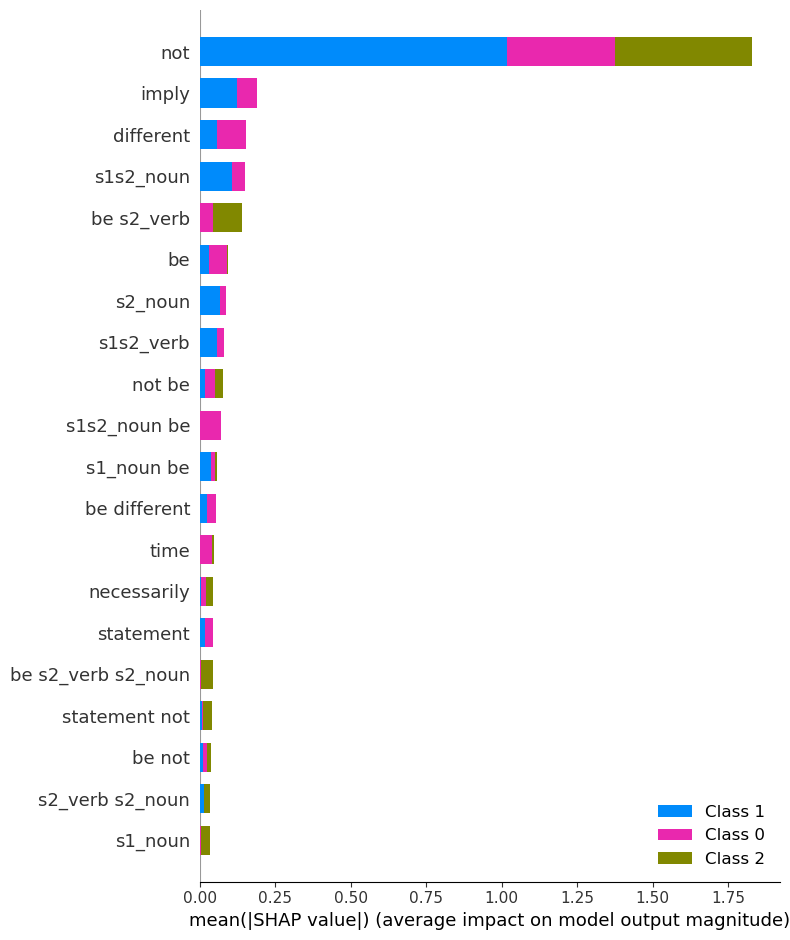

In [524]:
shap.summary_plot(shap_values, features=X, feature_names=vectorizer.get_feature_names_out())

## Full Explanation

### Naive Bayes

In [525]:
vectorizer = CountVectorizer(ngram_range=(1, 3))
X = vectorizer.fit_transform(gpt_pred.pred_explanation)

In [526]:
print(X.toarray())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [527]:
X_train, X_test, y_train, y_test = train_test_split(X.toarray(), pd.Series([x.lower() for x in gpt_pred.pred_label]), test_size=0.5, random_state=12345)

In [528]:
mnb = MultinomialNB()
y_pred = mnb.fit(X_train, y_train).predict(X_test)
print("Number of mislabeled points out of in total %d points : %d"
      % (X_test.shape[0], (y_test != y_pred).sum()))
print(f"Accuracy: {(y_test == y_pred).mean()}")

Number of mislabeled points out of in total 500 points : 78
Accuracy: 0.844


In [529]:
metrics.confusion_matrix(y_test, y_pred)

array([[138,  18,  13],
       [ 17, 218,  10],
       [ 11,   9,  66]])

In [530]:
y_train.value_counts() / y_train.shape[0]

entailment       0.476
contradiction    0.366
neutral          0.158
dtype: float64

In [531]:
np.exp(mnb.class_log_prior_)

array([0.366, 0.476, 0.158])

In [532]:
cond_prob_Xi_given_not_yj = np.zeros(mnb.feature_log_prob_.shape)
for j in range(3):
    log_joint_prob_m = mnb.feature_log_prob_[j != np.array([0,1,2]),:][0,:] + mnb.class_log_prior_[j != np.array([0,1,2])][0]
    log_joint_prob_k = mnb.feature_log_prob_[j != np.array([0,1,2]),:][1,:] + mnb.class_log_prior_[j != np.array([0,1,2])][1]
    joint_prob_not_j = np.exp(log_joint_prob_m) + np.exp(log_joint_prob_k)
    cond_prob_Xi_given_not_yj[j,:] = joint_prob_not_j / (1 - np.exp(mnb.class_log_prior_[j]))
prob_increase = (np.exp(mnb.feature_log_prob_) - cond_prob_Xi_given_not_yj) / cond_prob_Xi_given_not_yj * np.exp(mnb.feature_log_prob_)

In [533]:
nb_results_full["gpt3_contradiction"] = vectorizer.get_feature_names_out()[prob_increase.argsort()[0,::-1]][:50]
nb_results_full["gpt3_entailment"] = vectorizer.get_feature_names_out()[prob_increase.argsort()[1,::-1]][:50]
nb_results_full["gpt3_neutral"] = vectorizer.get_feature_names_out()[prob_increase.argsort()[2,::-1]][:50]
vectorizer.get_feature_names_out()[prob_increase.argsort()[:,::-1]][:50]

array([['cannot', 'same time', 'at the same', ..., 'of', 'the', 'is'],
       ['implies', 'implies that', 'implies that the', ..., 'same',
        'the same', 'be'],
       ['just', 'because', 'just because', ..., 'are', 'is', 'the']],
      dtype=object)

### XGBoost

In [534]:
xg_reg = xgb.XGBClassifier(colsample_bytree = 0.3, learning_rate = 0.1,
                          max_depth = 5, alpha = 10, n_estimators = 100)
y_train_numeric = np.array([0 if x == "contradiction" else x for x in y_train])
y_train_numeric = np.array([1 if x == "entailment" else x for x in y_train_numeric])
y_train_numeric = np.array([2 if x == "neutral" else x for x in y_train_numeric]).astype(int)

y_test_numeric = np.array([0 if x == "contradiction" else x for x in y_test])
y_test_numeric = np.array([1 if x == "entailment" else x for x in y_test_numeric])
y_test_numeric = np.array([2 if x == "neutral" else x for x in y_test_numeric]).astype(int)

xg_reg.fit(X_train,y_train_numeric)
#xg_reg.fit(X_train,np.repeat(1,X_train.shape[0]))

preds = xg_reg.predict(X_test)

In [535]:
print("Number of mislabeled points out of in total %d points : %d"
      % (X_test.shape[0], (y_test_numeric != preds).sum()))
print(f"Accuracy: {(y_test_numeric == preds).mean()}")

Number of mislabeled points out of in total 500 points : 73
Accuracy: 0.854


In [536]:
shap.initjs()
explainer = shap.TreeExplainer(xg_reg)
shap_values = explainer.shap_values(X)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [537]:
vectorizer.get_feature_names_out()[xg_reg.feature_importances_.argsort()[::-1]]

array(['not', 'does not mean', 'cannot', ..., 'possible',
       'posing with the', '10'], dtype=object)

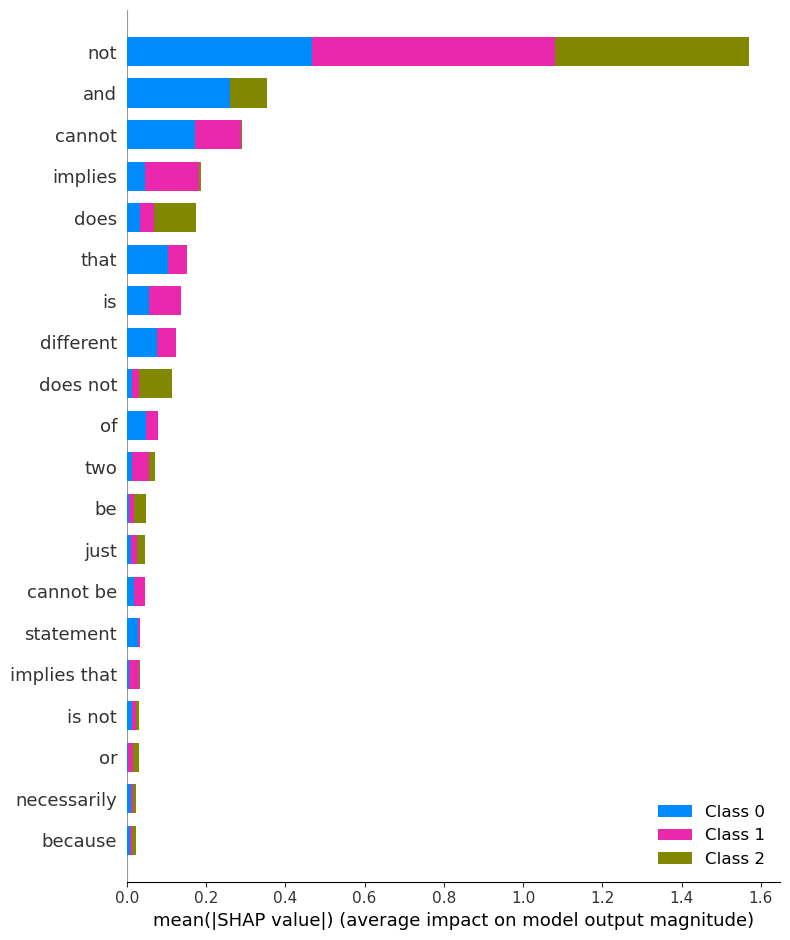

In [538]:
shap.summary_plot(shap_values, features=X, feature_names=vectorizer.get_feature_names_out())

# Reduced GPT-2 Explanations

## SVO Structure

### Naive Bayes

In [539]:
vectorizer = CountVectorizer(ngram_range=(1, 3))
X = vectorizer.fit_transform(gpt2.reduced_expl)

In [540]:
print(X.toarray())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [541]:
X_train, X_test, y_train, y_test = train_test_split(X.toarray(), gpt2.pred_label, test_size=0.5, random_state=12345)

In [542]:
mnb = MultinomialNB()
y_pred = mnb.fit(X_train, y_train).predict(X_test)
print("Number of mislabeled points out of in total %d points : %d"
      % (X_test.shape[0], (y_test != y_pred).sum()))
print(f"Accuracy: {(y_test == y_pred).mean()}")

Number of mislabeled points out of in total 500 points : 173
Accuracy: 0.654


In [543]:
metrics.confusion_matrix(y_test, y_pred)

array([[120,  23,  27],
       [ 30,  78,  44],
       [ 15,  34, 129]])

In [544]:
y_train.value_counts() / y_train.shape[0]

0    0.384
1    0.330
2    0.286
Name: pred_label, dtype: float64

In [545]:
np.exp(mnb.class_log_prior_)

array([0.384, 0.33 , 0.286])

In [546]:
cond_prob_Xi_given_not_yj = np.zeros(mnb.feature_log_prob_.shape)
for j in range(3):
    log_joint_prob_m = mnb.feature_log_prob_[j != np.array([0,1,2]),:][0,:] + mnb.class_log_prior_[j != np.array([0,1,2])][0]
    log_joint_prob_k = mnb.feature_log_prob_[j != np.array([0,1,2]),:][1,:] + mnb.class_log_prior_[j != np.array([0,1,2])][1]
    joint_prob_not_j = np.exp(log_joint_prob_m) + np.exp(log_joint_prob_k)
    cond_prob_Xi_given_not_yj[j,:] = joint_prob_not_j / (1 - np.exp(mnb.class_log_prior_[j]))
prob_increase = (np.exp(mnb.feature_log_prob_) - cond_prob_Xi_given_not_yj) / cond_prob_Xi_given_not_yj * np.exp(mnb.feature_log_prob_)

In [547]:
nb_results_SVO["gpt2_contradiction"] = vectorizer.get_feature_names_out()[prob_increase.argsort()[0,::-1]][:50]
nb_results_SVO["gpt2_neutral"] = vectorizer.get_feature_names_out()[prob_increase.argsort()[1,::-1]][:50]
nb_results_SVO["gpt2_entailment"] = vectorizer.get_feature_names_out()[prob_increase.argsort()[2,::-1]][:50]
vectorizer.get_feature_names_out()[prob_increase.argsort()[:,::-1]][:50]

array([['s2_verb same', 'same', 's1s2_subj not', ..., 's1s2_verb',
        's1s2_subj', 'be'],
       ['not mean', 'not mean s2_verb', 'mean s2_verb', ..., 's1_verb',
        's1_subj', 'be'],
       ['be', 's1_subj be s2_subj', 'be s2_subj', ..., 'not', 's1_verb',
        's2_verb']], dtype=object)

### XGBoost

In [548]:
xg_reg = xgb.XGBClassifier(colsample_bytree = 0.3, learning_rate = 0.1,
                          max_depth = 5, alpha = 10, n_estimators = 100)
y_train_numeric = np.array([0 if x == "contradiction" else x for x in y_train])
y_train_numeric = np.array([1 if x == "entailment" else x for x in y_train_numeric])
y_train_numeric = np.array([2 if x == "neutral" else x for x in y_train_numeric]).astype(int)

y_test_numeric = np.array([0 if x == "contradiction" else x for x in y_test])
y_test_numeric = np.array([1 if x == "entailment" else x for x in y_test_numeric])
y_test_numeric = np.array([2 if x == "neutral" else x for x in y_test_numeric]).astype(int)

xg_reg.fit(X_train,y_train_numeric)
#xg_reg.fit(X_train,np.repeat(1,X_train.shape[0]))

preds = xg_reg.predict(X_test)

In [549]:
print("Number of mislabeled points out of in total %d points : %d"
      % (X_test.shape[0], (y_test_numeric != preds).sum()))
print(f"Accuracy: {(y_test_numeric == preds).mean()}")

Number of mislabeled points out of in total 500 points : 154
Accuracy: 0.692


In [550]:
shap.initjs()
explainer = shap.TreeExplainer(xg_reg)
shap_values = explainer.shap_values(X)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [551]:
vectorizer.get_feature_names_out()[xg_reg.feature_importances_.argsort()[::-1]]

array(['not', 'not mean s2_verb', 'mean', ..., 's1s2_subj not play',
       's1s2_subj not pose', 'advertise'], dtype=object)

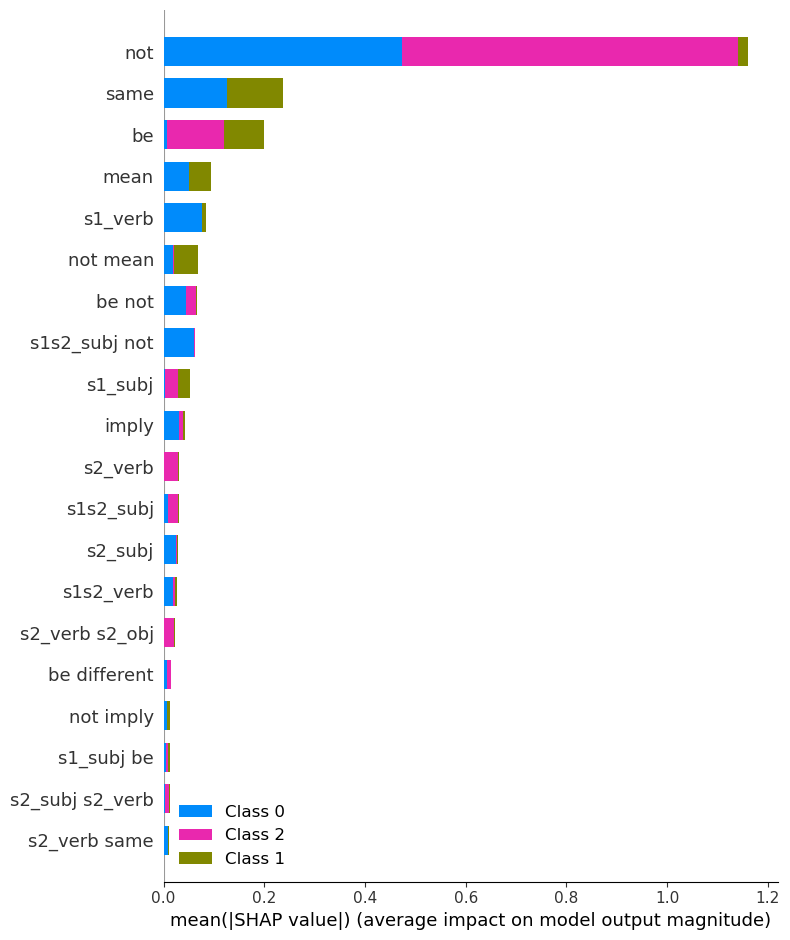

In [552]:
shap.summary_plot(shap_values, features=X, feature_names=vectorizer.get_feature_names_out())

## POS Tags

### Naive Bayes

In [553]:
vectorizer = CountVectorizer(ngram_range=(1, 3))
X = vectorizer.fit_transform(gpt2.pos_expl)

In [554]:
print(X.toarray())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [555]:
X_train, X_test, y_train, y_test = train_test_split(X.toarray(), gpt2.pred_label, test_size=0.5, random_state=12345)

In [556]:
y_test.value_counts() / y_test.shape[0]

2    0.356
0    0.340
1    0.304
Name: pred_label, dtype: float64

In [557]:
mnb = MultinomialNB()
y_pred = mnb.fit(X_train, y_train).predict(X_test)
print("Number of mislabeled points out of in total %d points : %d"
      % (X_test.shape[0], (y_test != y_pred).sum()))
print(f"Accuracy: {(y_test == y_pred).mean()}")

Number of mislabeled points out of in total 500 points : 114
Accuracy: 0.772


In [558]:
metrics.confusion_matrix(y_test, y_pred)

array([[131,  19,  20],
       [ 16, 118,  18],
       [  8,  33, 137]])

In [559]:
y_train.value_counts() / y_train.shape[0]

0    0.384
1    0.330
2    0.286
Name: pred_label, dtype: float64

In [560]:
np.exp(mnb.class_log_prior_)

array([0.384, 0.33 , 0.286])

In [561]:
cond_prob_Xi_given_not_yj = np.zeros(mnb.feature_log_prob_.shape)
for j in range(3):
    log_joint_prob_m = mnb.feature_log_prob_[j != np.array([0,1,2]),:][0,:] + mnb.class_log_prior_[j != np.array([0,1,2])][0]
    log_joint_prob_k = mnb.feature_log_prob_[j != np.array([0,1,2]),:][1,:] + mnb.class_log_prior_[j != np.array([0,1,2])][1]
    joint_prob_not_j = np.exp(log_joint_prob_m) + np.exp(log_joint_prob_k)
    cond_prob_Xi_given_not_yj[j,:] = joint_prob_not_j / (1 - np.exp(mnb.class_log_prior_[j]))
prob_increase = (np.exp(mnb.feature_log_prob_) - cond_prob_Xi_given_not_yj) / cond_prob_Xi_given_not_yj * np.exp(mnb.feature_log_prob_)

In [562]:
nb_results_POS["gpt2_contradiction"] = vectorizer.get_feature_names_out()[prob_increase.argsort()[0,::-1]][:50]
nb_results_POS["gpt2_neutral"] = vectorizer.get_feature_names_out()[prob_increase.argsort()[1,::-1]][:50]
nb_results_POS["gpt2_entailment"] = vectorizer.get_feature_names_out()[prob_increase.argsort()[2,::-1]][:50]
vectorizer.get_feature_names_out()[prob_increase.argsort()[:,::-1]][:50]

array([['time', 'not be s1_verb', 'not be', ..., 's1s2_verb',
        's1s2_noun be', 's1s2_noun'],
       ['not mean', 'mean', 's1_noun not mean', ..., 's1_verb',
        's1_noun', 'be'],
       ['s1s2_noun', 'be s1s2_noun', 's1s2_noun be s1s2_verb', ...,
        'not', 's1_verb', 's2_noun']], dtype=object)

### XGBoost

In [563]:
xg_reg = xgb.XGBClassifier(colsample_bytree = 0.3, learning_rate = 0.1,
                          max_depth = 5, alpha = 10, n_estimators = 100)
y_train_numeric = y_train

y_test_numeric = y_test

xg_reg.fit(X_train,y_train_numeric)

preds = xg_reg.predict(X_test)

In [564]:
np.mean([preds[i] == y_test_numeric.iloc[i] for i in range(len(preds))])

0.766

In [565]:
print("Number of mislabeled points out of in total %d points : %d"
      % (X_test.shape[0], (y_test_numeric != preds).sum()))
print(f"Accuracy: {(y_test_numeric == preds).mean()}")

Number of mislabeled points out of in total 500 points : 117
Accuracy: 0.766


In [566]:
shap.initjs()
explainer = shap.TreeExplainer(xg_reg)
shap_values = explainer.shap_values(X)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [567]:
vectorizer.get_feature_names_out()[xg_reg.feature_importances_.argsort()[::-1]]

array(['not', 'not be', 'not mean be', ...,
       's1s2_adj s1s2_noun s1s2_verb', 's1s2_adj s1s2_noun s2_noun',
       'action'], dtype=object)

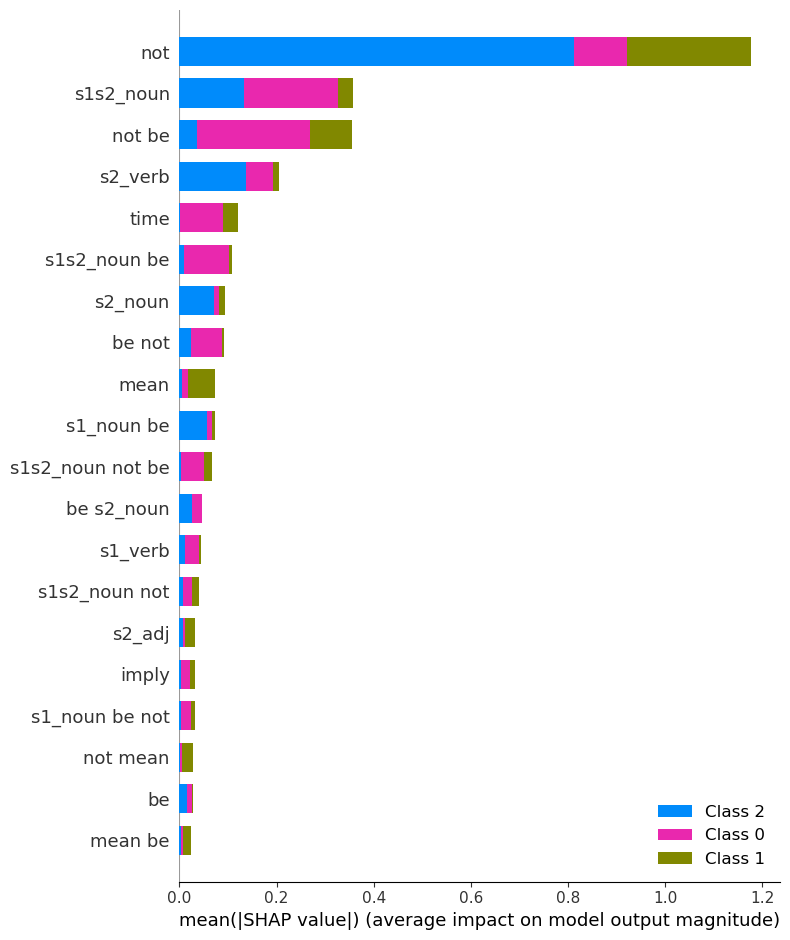

In [568]:
shap.summary_plot(shap_values, features=X, feature_names=vectorizer.get_feature_names_out())

## Full Explanation

### Naive Bayes

In [569]:
vectorizer = CountVectorizer(ngram_range=(1, 3))
X = vectorizer.fit_transform(gpt2.generated)

In [570]:
print(X.toarray())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [571]:
X_train, X_test, y_train, y_test = train_test_split(X.toarray(), gpt2.pred_label, test_size=0.5, random_state=12345)

In [572]:
y_test.value_counts() / y_test.shape[0]

2    0.356
0    0.340
1    0.304
Name: pred_label, dtype: float64

In [573]:
mnb = MultinomialNB()
y_pred = mnb.fit(X_train, y_train).predict(X_test)
print("Number of mislabeled points out of in total %d points : %d"
      % (X_test.shape[0], (y_test != y_pred).sum()))
print(f"Accuracy: {(y_test == y_pred).mean()}")

Number of mislabeled points out of in total 500 points : 133
Accuracy: 0.734


In [574]:
metrics.confusion_matrix(y_test, y_pred)

array([[120,  41,   9],
       [ 17, 122,  13],
       [ 18,  35, 125]])

In [575]:
y_train.value_counts() / y_train.shape[0]

0    0.384
1    0.330
2    0.286
Name: pred_label, dtype: float64

In [576]:
np.exp(mnb.class_log_prior_)

array([0.384, 0.33 , 0.286])

In [577]:
cond_prob_Xi_given_not_yj = np.zeros(mnb.feature_log_prob_.shape)
for j in range(3):
    log_joint_prob_m = mnb.feature_log_prob_[j != np.array([0,1,2]),:][0,:] + mnb.class_log_prior_[j != np.array([0,1,2])][0]
    log_joint_prob_k = mnb.feature_log_prob_[j != np.array([0,1,2]),:][1,:] + mnb.class_log_prior_[j != np.array([0,1,2])][1]
    joint_prob_not_j = np.exp(log_joint_prob_m) + np.exp(log_joint_prob_k)
    cond_prob_Xi_given_not_yj[j,:] = joint_prob_not_j / (1 - np.exp(mnb.class_log_prior_[j]))
prob_increase = (np.exp(mnb.feature_log_prob_) - cond_prob_Xi_given_not_yj) / cond_prob_Xi_given_not_yj * np.exp(mnb.feature_log_prob_)

In [578]:
nb_results_full["gpt2_contradiction"] = vectorizer.get_feature_names_out()[prob_increase.argsort()[0,::-1]][:50]
nb_results_full["gpt2_neutral"] = vectorizer.get_feature_names_out()[prob_increase.argsort()[1,::-1]][:50]
nb_results_full["gpt2_entailment"] = vectorizer.get_feature_names_out()[prob_increase.argsort()[2,::-1]][:50]
vectorizer.get_feature_names_out()[prob_increase.argsort()[:,::-1]][:50]

array([['cannot', 'same time', 'time', ..., 'in', 'are', 'is'],
       ['not all', 'all', 'mean', ..., 'at', 'and', 'the'],
       ['is', 'four', 'is the same', ..., 'not', 'and', 'the']],
      dtype=object)

### XGBoost

In [579]:
xg_reg = xgb.XGBClassifier(colsample_bytree = 0.3, learning_rate = 0.1,
                          max_depth = 5, alpha = 10, n_estimators = 100)
y_train_numeric = y_train

y_test_numeric = y_test

xg_reg.fit(X_train,y_train_numeric)

preds = xg_reg.predict(X_test)

In [580]:
np.mean([preds[i] == y_test_numeric.iloc[i] for i in range(len(preds))])

0.762

In [581]:
print("Number of mislabeled points out of in total %d points : %d"
      % (X_test.shape[0], (y_test_numeric != preds).sum()))
print(f"Accuracy: {(y_test_numeric == preds).mean()}")

Number of mislabeled points out of in total 500 points : 119
Accuracy: 0.762


In [582]:
shap.initjs()
explainer = shap.TreeExplainer(xg_reg)
shap_values = explainer.shap_values(X)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [583]:
vectorizer.get_feature_names_out()[xg_reg.feature_importances_.argsort()[::-1]]

array(['the same time', 'same time', 'be', ..., 'people transport trash',
       'people transport', 'about'], dtype=object)

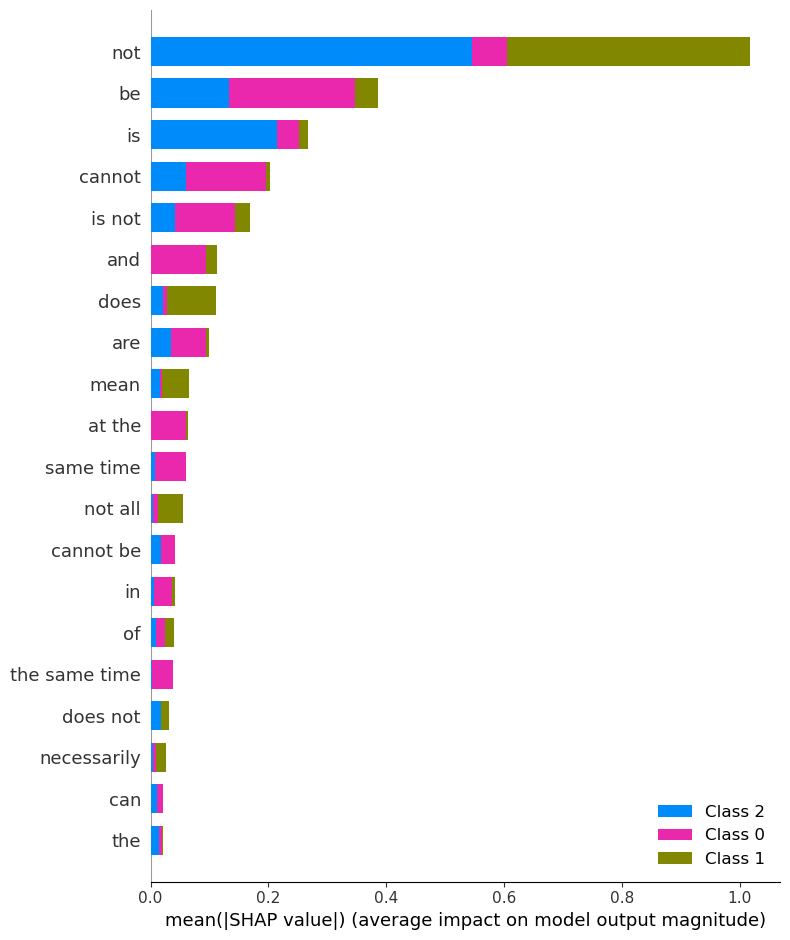

In [584]:
shap.summary_plot(shap_values, features=X, feature_names=vectorizer.get_feature_names_out())

# Reduced Gold Explanations

## SVO Structure

In [585]:
vectorizer = CountVectorizer(ngram_range=(1, 3))
X = vectorizer.fit_transform(gpt_pred.reduced_gold_expl)

### Naive Bayes

In [586]:
print(X.toarray())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [587]:
X_train, X_test, y_train, y_test = train_test_split(X.toarray(), pd.Series([x.lower() for x in gpt_pred.gold_label]), test_size=0.5, random_state=12345)

In [588]:
y_test.value_counts() / y_test.shape[0]

entailment       0.370
contradiction    0.318
neutral          0.312
dtype: float64

In [589]:
mnb = MultinomialNB()
y_pred = mnb.fit(X_train, y_train).predict(X_test)
print("Number of mislabeled points out of in total %d points : %d"
      % (X_test.shape[0], (y_test != y_pred).sum()))
print(f"Accuracy: {(y_test == y_pred).mean()}")

Number of mislabeled points out of in total 500 points : 168
Accuracy: 0.664


In [590]:
metrics.confusion_matrix(y_test, y_pred)

array([[105,  32,  22],
       [ 19, 142,  24],
       [ 31,  40,  85]])

In [591]:
y_train.value_counts() / y_train.shape[0]

entailment       0.360
contradiction    0.354
neutral          0.286
dtype: float64

In [592]:
np.exp(mnb.class_log_prior_)

array([0.354, 0.36 , 0.286])

In [593]:
cond_prob_Xi_given_not_yj = np.zeros(mnb.feature_log_prob_.shape)
for j in range(3):
    log_joint_prob_m = mnb.feature_log_prob_[j != np.array([0,1,2]),:][0,:] + mnb.class_log_prior_[j != np.array([0,1,2])][0]
    log_joint_prob_k = mnb.feature_log_prob_[j != np.array([0,1,2]),:][1,:] + mnb.class_log_prior_[j != np.array([0,1,2])][1]
    joint_prob_not_j = np.exp(log_joint_prob_m) + np.exp(log_joint_prob_k)
    cond_prob_Xi_given_not_yj[j,:] = joint_prob_not_j / (1 - np.exp(mnb.class_log_prior_[j]))
prob_increase = (np.exp(mnb.feature_log_prob_) - cond_prob_Xi_given_not_yj) / cond_prob_Xi_given_not_yj * np.exp(mnb.feature_log_prob_)

In [594]:
nb_results_SVO["gold_contradiction"] = vectorizer.get_feature_names_out()[prob_increase.argsort()[0,::-1]][:50]
nb_results_SVO["gold_entailment"] = vectorizer.get_feature_names_out()[prob_increase.argsort()[1,::-1]][:50]
nb_results_SVO["gold_neutral"] = vectorizer.get_feature_names_out()[prob_increase.argsort()[2,::-1]][:50]
vectorizer.get_feature_names_out()[prob_increase.argsort()[:,::-1]][:50]

array([['not be', 'be not', 'not', ..., 'be be', 's1s2_verb',
        's1s2_subj'],
       ['s1s2_verb', 'be', 's1s2_subj', ..., 'same', 'mean', 's2_verb'],
       ['not mean', 'not imply', 'mean', ..., 's1s2_subj', 's1_subj',
        'be']], dtype=object)

### XGBoost

In [595]:
xg_reg = xgb.XGBClassifier(colsample_bytree = 0.3, learning_rate = 0.1,
                          max_depth = 5, alpha = 10, n_estimators = 100)
y_train_numeric = np.array([0 if x == "contradiction" else x for x in y_train])
y_train_numeric = np.array([1 if x == "entailment" else x for x in y_train_numeric])
y_train_numeric = np.array([2 if x == "neutral" else x for x in y_train_numeric]).astype(int)

y_test_numeric = np.array([0 if x == "contradiction" else x for x in y_test])
y_test_numeric = np.array([1 if x == "entailment" else x for x in y_test_numeric])
y_test_numeric = np.array([2 if x == "neutral" else x for x in y_test_numeric]).astype(int)

xg_reg.fit(X_train,y_train_numeric)

preds = xg_reg.predict(X_test)

In [596]:
np.mean([preds[i] == y_test_numeric[i] for i in range(len(preds))])

0.684

In [597]:
print("Number of mislabeled points out of in total %d points : %d"
      % (X_test.shape[0], (y_test_numeric != preds).sum()))
print(f"Accuracy: {(y_test_numeric == preds).mean()}")

Number of mislabeled points out of in total 500 points : 158
Accuracy: 0.684


In [598]:
shap.initjs()
explainer = shap.TreeExplainer(xg_reg)
shap_values = explainer.shap_values(X)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [599]:
vectorizer.get_feature_names_out()[xg_reg.feature_importances_.argsort()[::-1]]

array(['not', 'not mean s2_verb', 'not imply', ...,
       's1s2_subj ride s1_verb', 's1s2_subj ride s1s2_verb', 'add'],
      dtype=object)

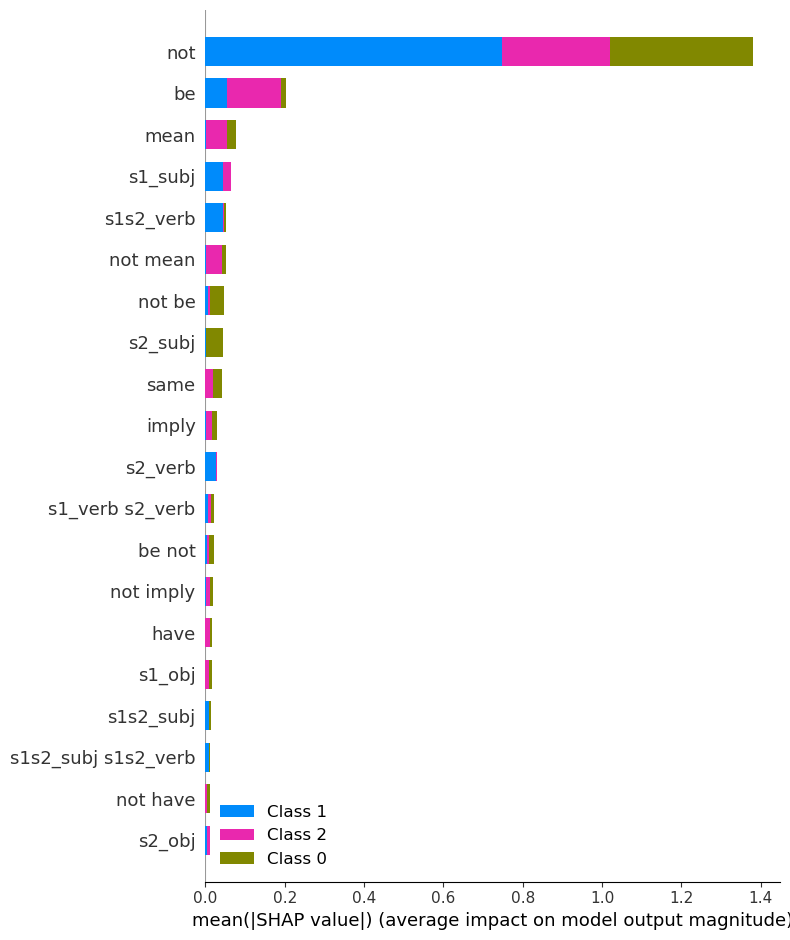

In [600]:
shap.summary_plot(shap_values, features=X, feature_names=vectorizer.get_feature_names_out())

## POS Tags

### Naive Bayes

In [601]:
vectorizer = CountVectorizer(ngram_range=(1, 2))
X = vectorizer.fit_transform(gpt_pred.pos_gold_expl)

In [602]:
print(X.toarray())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [603]:
X_train, X_test, y_train, y_test = train_test_split(X.toarray(), pd.Series([x.lower() for x in gpt_pred.gold_label]), test_size=0.3, random_state=12345)

In [604]:
y_test.value_counts() / y_test.shape[0]

entailment       0.353333
contradiction    0.326667
neutral          0.320000
dtype: float64

In [605]:
mnb = MultinomialNB()
y_pred = mnb.fit(X_train, y_train).predict(X_test)
print("Number of mislabeled points out of in total %d points : %d"
      % (X_test.shape[0], (y_test != y_pred).sum()))
print(f"Accuracy: {(y_test == y_pred).mean()}")

Number of mislabeled points out of in total 300 points : 59
Accuracy: 0.8033333333333333


In [606]:
metrics.confusion_matrix(y_test, y_pred)

array([[81,  9,  8],
       [11, 89,  6],
       [15, 10, 71]])

In [607]:
y_train.value_counts() / y_train.shape[0]

entailment       0.37
contradiction    0.34
neutral          0.29
dtype: float64

In [608]:
np.exp(mnb.class_log_prior_)

array([0.34, 0.37, 0.29])

In [609]:
cond_prob_Xi_given_not_yj = np.zeros(mnb.feature_log_prob_.shape)
for j in range(3):
    log_joint_prob_m = mnb.feature_log_prob_[j != np.array([0,1,2]),:][0,:] + mnb.class_log_prior_[j != np.array([0,1,2])][0]
    log_joint_prob_k = mnb.feature_log_prob_[j != np.array([0,1,2]),:][1,:] + mnb.class_log_prior_[j != np.array([0,1,2])][1]
    joint_prob_not_j = np.exp(log_joint_prob_m) + np.exp(log_joint_prob_k)
    cond_prob_Xi_given_not_yj[j,:] = joint_prob_not_j / (1 - np.exp(mnb.class_log_prior_[j]))
prob_increase = (np.exp(mnb.feature_log_prob_) - cond_prob_Xi_given_not_yj) / cond_prob_Xi_given_not_yj * np.exp(mnb.feature_log_prob_)

In [610]:
nb_results_POS["gold_contradiction"] = vectorizer.get_feature_names_out()[prob_increase.argsort()[0,::-1]][:50]
nb_results_POS["gold_entailment"] = vectorizer.get_feature_names_out()[prob_increase.argsort()[1,::-1]][:50]
nb_results_POS["gold_neutral"] = vectorizer.get_feature_names_out()[prob_increase.argsort()[2,::-1]][:50]
vectorizer.get_feature_names_out()[prob_increase.argsort()[:,::-1]][:50]

array([['time', 'not be', 'simultaneously', ..., 's1s2_noun be',
        's1s2_verb', 's1s2_noun'],
       ['s1s2_noun', 's1s2_noun s1s2_verb', 's1s2_verb', ..., 's1_verb',
        's2_verb', 's2_noun'],
       ['not mean', 'necessarily', 'not imply', ..., 'be', 's1_noun',
        's1s2_noun']], dtype=object)

### XGBoost

In [611]:
xg_reg = xgb.XGBClassifier(colsample_bytree = 0.3, learning_rate = 0.1,
                          max_depth = 5, alpha = 10, n_estimators = 100)
y_train_numeric = np.array([0 if x == "contradiction" else x for x in y_train])
y_train_numeric = np.array([1 if x == "entailment" else x for x in y_train_numeric])
y_train_numeric = np.array([2 if x == "neutral" else x for x in y_train_numeric]).astype(int)

y_test_numeric = np.array([0 if x == "contradiction" else x for x in y_test])
y_test_numeric = np.array([1 if x == "entailment" else x for x in y_test_numeric])
y_test_numeric = np.array([2 if x == "neutral" else x for x in y_test_numeric]).astype(int)

xg_reg.fit(X_train,y_train_numeric)
#xg_reg.fit(X_train,np.repeat(1,X_train.shape[0]))

preds = xg_reg.predict(X_test)

In [612]:
print("Number of mislabeled points out of in total %d points : %d"
      % (X_test.shape[0], (y_test_numeric != preds).sum()))
print(f"Accuracy: {(y_test_numeric == preds).mean()}")

Number of mislabeled points out of in total 300 points : 67
Accuracy: 0.7766666666666666


In [613]:
shap.initjs()
explainer = shap.TreeExplainer(xg_reg)
shap_values = explainer.shap_values(X)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [614]:
vectorizer.get_feature_names_out()[xg_reg.feature_importances_.argsort()[::-1]]

array(['not', 'not be', 's1s2_noun', ..., 's1_noun weather',
       's1_noun will', 'able'], dtype=object)

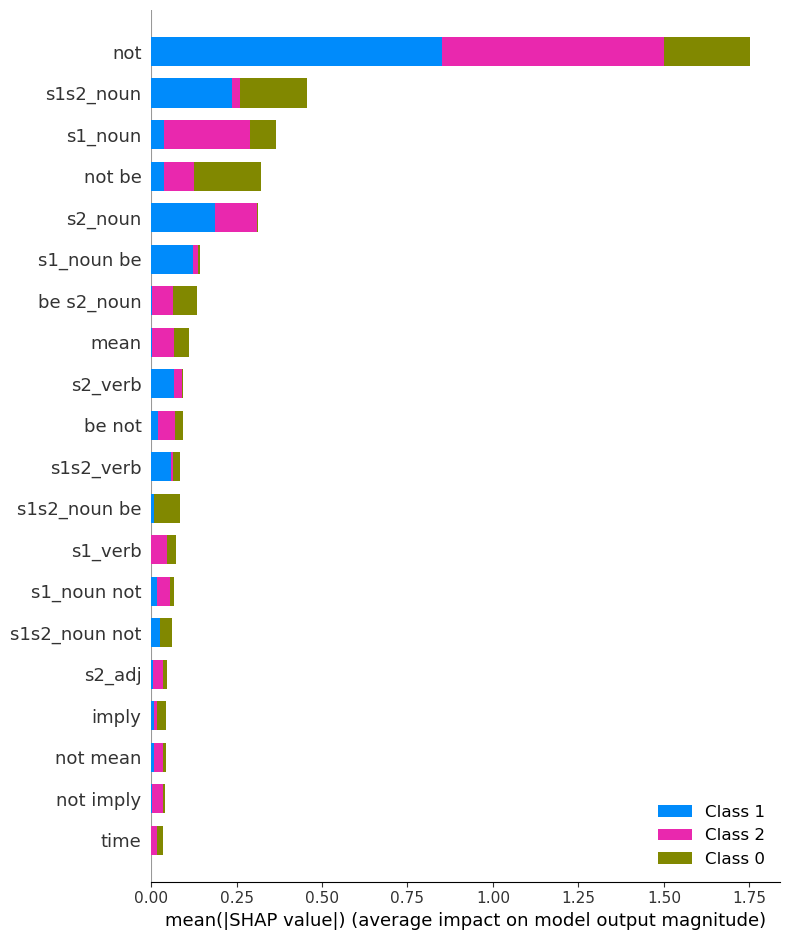

In [615]:
shap.summary_plot(shap_values, features=X, feature_names=vectorizer.get_feature_names_out())

## Full Gold Explanations

In [616]:
vectorizer = CountVectorizer(ngram_range=(1, 3))
X = vectorizer.fit_transform(gpt_pred.Explanation_1)

### Naive Bayes

In [617]:
print(X.toarray())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [618]:
X_train, X_test, y_train, y_test = train_test_split(X.toarray(), pd.Series([x.lower() for x in gpt_pred.gold_label]), test_size=0.5, random_state=12345)

In [619]:
y_test.value_counts() / y_test.shape[0]

entailment       0.370
contradiction    0.318
neutral          0.312
dtype: float64

In [620]:
mnb = MultinomialNB()
y_pred = mnb.fit(X_train, y_train).predict(X_test)
print("Number of mislabeled points out of in total %d points : %d"
      % (X_test.shape[0], (y_test != y_pred).sum()))
print(f"Accuracy: {(y_test == y_pred).mean()}")

Number of mislabeled points out of in total 500 points : 103
Accuracy: 0.794


In [621]:
metrics.confusion_matrix(y_test, y_pred)

array([[129,  17,  13],
       [ 31, 130,  24],
       [ 12,   6, 138]])

In [622]:
y_train.value_counts() / y_train.shape[0]

entailment       0.360
contradiction    0.354
neutral          0.286
dtype: float64

In [623]:
np.exp(mnb.class_log_prior_)

array([0.354, 0.36 , 0.286])

In [624]:
cond_prob_Xi_given_not_yj = np.zeros(mnb.feature_log_prob_.shape)
for j in range(3):
    log_joint_prob_m = mnb.feature_log_prob_[j != np.array([0,1,2]),:][0,:] + mnb.class_log_prior_[j != np.array([0,1,2])][0]
    log_joint_prob_k = mnb.feature_log_prob_[j != np.array([0,1,2]),:][1,:] + mnb.class_log_prior_[j != np.array([0,1,2])][1]
    joint_prob_not_j = np.exp(log_joint_prob_m) + np.exp(log_joint_prob_k)
    cond_prob_Xi_given_not_yj[j,:] = joint_prob_not_j / (1 - np.exp(mnb.class_log_prior_[j]))
prob_increase = (np.exp(mnb.feature_log_prob_) - cond_prob_Xi_given_not_yj) / cond_prob_Xi_given_not_yj * np.exp(mnb.feature_log_prob_)

In [625]:
nb_results_full["gold_contradiction"] = vectorizer.get_feature_names_out()[prob_increase.argsort()[0,::-1]][:50]
nb_results_full["gold_entailment"] = vectorizer.get_feature_names_out()[prob_increase.argsort()[1,::-1]][:50]
nb_results_full["gold_neutral"] = vectorizer.get_feature_names_out()[prob_increase.argsort()[2,::-1]][:50]
vectorizer.get_feature_names_out()[prob_increase.argsort()[:,::-1]][:50]

array([['cannot', 'cannot be', 'either', ..., 'in', 'are', 'is'],
       ['of', 'rephrasing', 'is', ..., 'at', 'and', 'be'],
       ['mean', 'does not', 'just', ..., 'and', 'the', 'is']],
      dtype=object)

### XGBoost

In [626]:
xg_reg = xgb.XGBClassifier(colsample_bytree = 0.3, learning_rate = 0.1,
                          max_depth = 5, alpha = 10, n_estimators = 100)
y_train_numeric = np.array([0 if x == "contradiction" else x for x in y_train])
y_train_numeric = np.array([1 if x == "entailment" else x for x in y_train_numeric])
y_train_numeric = np.array([2 if x == "neutral" else x for x in y_train_numeric]).astype(int)

y_test_numeric = np.array([0 if x == "contradiction" else x for x in y_test])
y_test_numeric = np.array([1 if x == "entailment" else x for x in y_test_numeric])
y_test_numeric = np.array([2 if x == "neutral" else x for x in y_test_numeric]).astype(int)

xg_reg.fit(X_train,y_train_numeric)

preds = xg_reg.predict(X_test)

In [627]:
np.mean([preds[i] == y_test_numeric[i] for i in range(len(preds))])

0.798

In [628]:
print("Number of mislabeled points out of in total %d points : %d"
      % (X_test.shape[0], (y_test_numeric != preds).sum()))
print(f"Accuracy: {(y_test_numeric == preds).mean()}")

Number of mislabeled points out of in total 500 points : 101
Accuracy: 0.798


In [629]:
shap.initjs()
explainer = shap.TreeExplainer(xg_reg)
shap_values = explainer.shap_values(X)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [630]:
vectorizer.get_feature_names_out()[xg_reg.feature_importances_.argsort()[::-1]]

array(['not', 'cannot be', 'mean they', ..., 'playing soccer there',
       'playing soccer is', '10'], dtype=object)

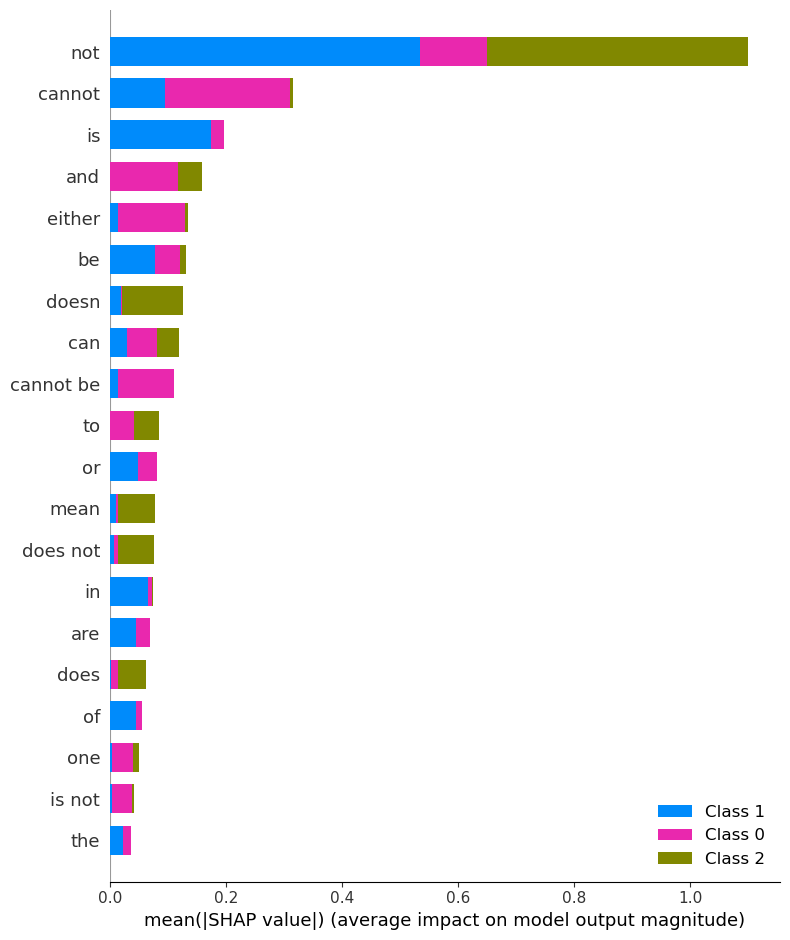

In [631]:
shap.summary_plot(shap_values, features=X, feature_names=vectorizer.get_feature_names_out())

# Save Results

In [632]:
nb_results_SVO = nb_results_SVO[["gpt3_contradiction", "gpt2_contradiction", "gold_contradiction", "gpt3_entailment", "gpt2_entailment", "gold_entailment", "gpt3_neutral", "gpt2_neutral", "gold_neutral"]]
nb_results_POS = nb_results_POS[["gpt3_contradiction", "gpt2_contradiction", "gold_contradiction", "gpt3_entailment", "gpt2_entailment", "gold_entailment", "gpt3_neutral", "gpt2_neutral", "gold_neutral"]]
nb_results_full = nb_results_full[["gpt3_contradiction", "gpt2_contradiction", "gold_contradiction", "gpt3_entailment", "gpt2_entailment", "gold_entailment", "gpt3_neutral", "gpt2_neutral", "gold_neutral"]]

In [633]:
nb_results_SVO.head()

,gpt3_contradiction,gpt2_contradiction,gold_contradiction,gpt3_entailment,gpt2_entailment,gold_entailment,gpt3_neutral,gpt2_neutral,gold_neutral
0,be different,s2_verb same,not be,imply,be,s1s2_verb,not mean,not mean,not mean
1,not,same,be not,imply s1s2_subj,s1_subj be s2_subj,be,mean,not mean s2_verb,not imply
2,different,s1s2_subj not,not,s1s2_verb,be s2_subj,s1s2_subj,not mean s2_verb,mean s2_verb,mean
3,be not,not,be different,s1s2_subj s1s2_verb,be be,s1s2_verb s1s2_subj,mean s2_verb,mean,not have
4,not same,s1_verb s2_verb same,not play,s1s2_subj,s1_subj be,s1s2_subj s1s2_verb,know,not imply,not


In [634]:
nb_results_POS.head()

,gpt3_contradiction,gpt2_contradiction,gold_contradiction,gpt3_entailment,gpt2_entailment,gold_entailment,gpt3_neutral,gpt2_neutral,gold_neutral
0,time,time,time,s1s2_noun,s1s2_noun,s1s2_noun,not mean,not mean,not mean
1,be different,not be s1_verb,not be,imply,be s1s2_noun,s1s2_noun s1s2_verb,mean,mean,necessarily
2,different,not be,simultaneously,imply s1s2_noun,s1s2_noun be s1s2_verb,s1s2_verb,not mean be,s1_noun not mean,not imply
3,not s2_noun,s1s2_noun not be,s2_noun time,s1s2_verb,s1s2_noun s1s2_noun s1s2_noun,s1s2_verb s1s2_noun,mean be,not mean be,not necessarily
4,not be,s2_verb time,be different,s1s2_noun imply,s1s2_noun be,s1s2_noun be,mean be s2_verb,mean be,mean be


In [635]:
nb_results_full.head()

,gpt3_contradiction,gpt2_contradiction,gold_contradiction,gpt3_entailment,gpt2_entailment,gold_entailment,gpt3_neutral,gpt2_neutral,gold_neutral
0,cannot,cannot,cannot,implies,is,of,just,not all,mean
1,same time,same time,cannot be,implies that,four,rephrasing,because,all,does not
2,at the same,time,either,implies that the,is the same,is,just because,mean,just
3,the same time,the same time,same time,that,type of,is rephrasing of,mean,not,does
4,cannot be,cannot be,the same time,is,is person,is rephrasing,does not,just,just because


In [636]:
nb_results_SVO.to_csv("../evaluation/naive_bayes_SVO.csv")
nb_results_POS.to_csv("../evaluation/naive_bayes_POS.csv")
nb_results_full.to_csv("../evaluation/naive_bayes_full.csv")

# Code for manual evaluation

In [637]:
np.random.seed(12345)
np.random.choice(range(1000), 1000, replace=False)

array([144, 833, 270, 468, 962, 186, 942, 516, 286, 458, 890, 957, 604,
       504, 474, 517, 173, 250, 967, 743, 258,  41, 719, 322, 911, 937,
       352, 795, 435, 521, 777, 593, 150, 138, 314, 725,   0, 884, 198,
       700, 912, 304, 883, 370, 199, 262,  73, 266, 732, 308, 671, 222,
       162, 479, 940, 440, 954, 977, 865,  17,  33, 332, 280, 127, 187,
         4, 358, 853, 915, 624, 599, 981, 298, 974, 493, 481, 757, 582,
       203,  56, 327, 437, 328, 320, 802, 153, 551, 484, 216, 727, 196,
       545, 560, 284, 136, 733, 821, 578, 106, 804, 101, 961, 603, 238,
       955, 462, 503, 765, 413, 754, 281, 239, 540, 268,  47, 220, 826,
       634, 430, 838, 696, 741, 966, 469, 254, 343, 758, 590, 117, 925,
       979, 997, 878, 334, 776, 625, 761, 400, 164, 913, 404, 914, 677,
       982, 609, 156, 190, 617, 680, 832, 104, 377, 746, 656, 207,   3,
       854, 829, 326,  65, 380,  53, 311, 768, 111, 509, 130, 664, 893,
       663, 158,  10, 943, 473, 488, 454, 569, 391, 589, 889, 13

In [638]:
gpt_pred[["Sentence1", "Sentence2", "pred_explanation", "pred_label", "gold_label"]][gpt_pred.pred_label != gpt_pred.gold_label]

,Sentence1,Sentence2,pred_explanation,pred_label,gold_label
4,A group of people stares at a wall that is fil...,A group of people analyze art together,Staring at drawings is a form of analyzing art.,entailment,neutral
10,"A woman, standing behind a girl, helping the g...",A mother is helping her child complete the exp...,A mother helping her child can be inferred fro...,entailment,neutral
12,Three girls jumping in front of a house's flow...,The girls are playing on a street.,We do not know if they are playing on a street...,neutral,contradiction
19,a group of skiers jumping down slopes with the...,The sun sets as a group of skiers finish a race.,"The sun is directly cast in the background, no...",contradiction,neutral
28,A boy lying on a hospital bed with his leg han...,a kid broke his leg,A kid with a broken leg would likely be lying ...,entailment,neutral
...,...,...,...,...,...
978,The German shepherd runs happily in the park.,Dog lays down outside.,The German Shepherd running in the park implie...,entailment,contradiction
979,A man in a colorful shirt and a lady in a whit...,Two people sign copies of their latest novel.,Two people signing copies of books does not ne...,neutral,entailment
986,Two people play horseshoes.,Tom and Sue were playing horseshoes.,Two people playing horseshoes implies Tom and ...,entailment,neutral
988,A middle-aged man in a green jacket is talking...,Two old friends catching up with each other.,Just because two middle-aged men are talking t...,neutral,entailment
